In [1]:
import tensorflow as tf
import os
import numpy as np
import pickle
import random
import scipy.misc as smp

In [2]:
SIZE = 512
CLASSES = 10
CHANNELS = 3

RUN_NAME = random.randint(0, 10000)
print("Current Run: " + str(RUN_NAME))

# Number generator filters
NGF = 32
# Number discrim filters
NDF = 64

SKIMP_LOAD = False

Current Run: 1150


In [3]:
from PIL import Image

data_path_A = "data/danbooru/danbooru2017/512px/"
data_path_B = "data/faces/lfw/"

def read_file(file_path):
    img = Image.open(file_path).resize((SIZE, SIZE), Image.ANTIALIAS)
    return np.array(img)[:,:,:CHANNELS].reshape((SIZE, SIZE, CHANNELS))

def load_dir(curr_path):
    images = []
    for file in os.listdir(curr_path):
        file_path = curr_path + "/" + file
        try:
            images.append(read_file(file_path))
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print("Failed to load " + file_path)
    return images
def load_data(path, lim=100000):
    images = []
    count = 0
    total = len(os.listdir(path))
    for sub_path in os.listdir(path):
        count += 1
        
        if SKIMP_LOAD and count % 10 != 0:
            continue
        if count > lim:
            continue
        
        curr_path = path + sub_path
        print("Loading {} | {} out of {} {}".format(curr_path, count, total, " "*50), end="\r")
        
        if os.path.isfile(curr_path):
            continue
        
        images += load_dir(curr_path)
        
    print("Finished loading files from {} {}".format(path, " "*50))
    
    return images

In [4]:
images_A = load_dir("data/paintings/monet2photo/trainA")#load_data(data_path_A, lim=1)
images_B = load_dir("data/paintings/monet2photo/trainB")#load_data(data_path_B)

#test_images = test_data[b'data']
#test_labels = test_data[b'labels']

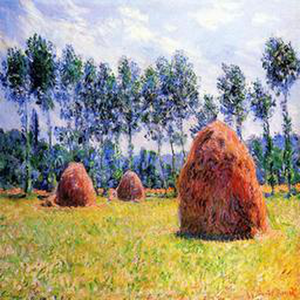

In [5]:
from PIL import Image 

def display_img(data):
    img = np.reshape(data, (SIZE,SIZE,CHANNELS))
    return Image.fromarray(img.astype("uint8")).resize((300,300), Image.ANTIALIAS)

display_img(images_A[random.randint(0, len(images_A))])

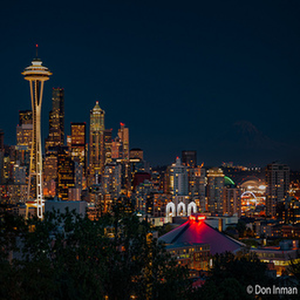

In [6]:
display_img(images_B[random.randint(0, len(images_B))])

In [7]:
sess = tf.InteractiveSession()

In [8]:
def conv2d(net, features, kernel, strides, padding="SAME"):
    if padding == "VALID":
        p = int((kernel - 1) / 2)
        net = tf.pad(net, [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
    return tf.layers.conv2d(net, features, kernel, strides, padding=padding)

def instance_norm(net):
    return tf.contrib.layers.batch_norm(net, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True)

    depth = net.get_shape()[3]
    scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))
    offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))
    mean, variance = tf.nn.moments(net, axes=[1,2], keep_dims=True)
    epsilon = 1e-5
    inv = tf.rsqrt(variance + epsilon)
    normalized = (input-mean)*inv
    return scale*normalized + offset
    
def lrelu(net, alpha=0.2):
    return tf.nn.leaky_relu(net, alpha)

def resnet_block(net, features):
    out_res = lrelu(instance_norm(conv2d(net, features, 3, 1, padding="VALID")))
    out_res = instance_norm(conv2d(out_res, features, 3, 1, padding="VALID"))

    return out_res + net

In [9]:
def generator(image, name, reuse=False):
    return res_generator(image, name, reuse)

def unet_generator(image, name, reuse=False, RES_BLOCKS=9):
    with tf.variable_scope(name, reuse=reuse):
        net = image
        
        unet_blocks = []

        net = lrelu(instance_norm(conv2d(net, NGF * 1, 7, 1, padding="VALID")))
        unet_blocks.append(net)
        
        net = lrelu(instance_norm(conv2d(net, NGF * 2, 3, 2, padding="SAME")))
        unet_blocks.append(net)
        
        net = lrelu(instance_norm(conv2d(net, NGF * 4, 3, 2, padding="SAME")))
        unet_blocks.append(net)

        for _ in range(RES_BLOCKS):
            net = resnet_block(net, NGF * 4)
            
        net = tf.concat([net, unet_blocks.pop()], 3)
        
        net = lrelu(instance_norm(tf.layers.conv2d_transpose(net, NGF * 2, 3, 2, padding="SAME")))
        net = tf.concat([net, unet_blocks.pop()], 3)
        
        net = lrelu(instance_norm(tf.layers.conv2d_transpose(net, NGF * 1, 3, 2, padding="SAME")))
        net = tf.concat([net, unet_blocks.pop()], 3)
        
        net = conv2d(net, CHANNELS, 7, 1, padding="VALID")

        return tf.tanh(net)
        
def res_generator(image, name, reuse=False, RES_BLOCKS=9):    
    with tf.variable_scope(name, reuse=reuse):
        net = image

        net = lrelu(instance_norm(conv2d(net, NGF * 1, 7, 1, padding="VALID")))
        net = lrelu(instance_norm(conv2d(net, NGF * 2, 3, 2, padding="SAME")))
        net = lrelu(instance_norm(conv2d(net, NGF * 4, 3, 2, padding="SAME")))


        for _ in range(RES_BLOCKS):
            net = resnet_block(net, NGF * 4)


        net = lrelu(instance_norm(tf.layers.conv2d_transpose(net, NGF * 2, 3, 2, padding="SAME")))
        net = lrelu(instance_norm(tf.layers.conv2d_transpose(net, NGF * 1, 3, 2, padding="SAME")))
        
        net = conv2d(net, CHANNELS, 7, 1, padding="VALID")

        return tf.tanh(net)

In [10]:
def discrim(image, name, reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        net = image

        net = lrelu(conv2d(net, NDF * 1, 4, 2, padding="SAME"))
        net = lrelu(instance_norm(conv2d(net, NDF * 2, 4, 2, padding="SAME")))
        net = lrelu(instance_norm(conv2d(net, NDF * 4, 4, 2, padding="SAME")))
        net = lrelu(instance_norm(conv2d(net, NDF * 8, 4, 2, padding="SAME")))
        
        net = conv2d(net, 1, 4, 1, padding="SAME")
        
        size = net.shape[1] * net.shape[2] * net.shape[3]
        net = tf.reshape(net, [-1, size])

        return tf.reduce_mean(tf.sigmoid(net), axis=1)
        
        #logits = tf.layers.dense(net, 1)
        #return tf.sigmoid(logits)  

In [11]:
input_A = tf.placeholder(tf.float32, [None, SIZE, SIZE, CHANNELS])
input_B = tf.placeholder(tf.float32, [None, SIZE, SIZE, CHANNELS])

In [12]:
gen_B = generator(input_A, "gen_AtoB")
gen_A = generator(input_B, "gen_BtoA")

discrim_A = discrim(input_A, "discrim_A")
discrim_B = discrim(input_B, "discrim_B")

discrim_A_on_B = discrim(input_B, "discrim_A", reuse=True)
discrim_B_on_A = discrim(input_A, "discrim_B", reuse=True)

discrim_gen_A = discrim(gen_A, "discrim_A", reuse=True)
discrim_gen_B = discrim(gen_B, "discrim_B", reuse=True)

cyc_A = generator(gen_B, "gen_BtoA", reuse=True)
cyc_B = generator(gen_A, "gen_AtoB", reuse=True)

In [13]:
D_A_loss_1 = tf.reduce_mean(tf.squared_difference(discrim_A, 1))
D_B_loss_1 = tf.reduce_mean(tf.squared_difference(discrim_B, 1))

D_A_loss_2 = tf.reduce_mean(tf.squared_difference(discrim_gen_A, 0))
D_B_loss_2 = tf.reduce_mean(tf.squared_difference(discrim_gen_B, 0))

D_A_loss_3 = tf.reduce_mean(tf.squared_difference(discrim_A_on_B, 0))
D_B_loss_3 = tf.reduce_mean(tf.squared_difference(discrim_B_on_A, 0))

D_A_accur = tf.reduce_mean(tf.round(discrim_A) + tf.round(1 - discrim_gen_A)) / 2
D_B_accur = tf.reduce_mean(tf.round(discrim_B) + tf.round(1 - discrim_gen_B)) / 2

D_A_loss = (D_A_loss_1 + D_A_loss_2) / 2
D_B_loss = (D_B_loss_1 + D_B_loss_2) / 2

In [14]:
G_BtoA_loss_1 = tf.reduce_mean(tf.squared_difference(discrim_gen_A, 1))
G_AtoB_loss_1 = tf.reduce_mean(tf.squared_difference(discrim_gen_B, 1))

#cyc_loss = (tf.losses.mean_squared_error(input_A, cyc_A) + tf.losses.mean_squared_error(input_B, cyc_B)) / 2
cyc_loss = tf.reduce_mean(tf.abs(input_A - cyc_A)) + tf.reduce_mean(tf.abs(input_B - cyc_B)) / 2
cyc_loss *= 10

G_BtoA_loss = G_BtoA_loss_1 + cyc_loss
G_AtoB_loss = G_AtoB_loss_1 + cyc_loss

In [15]:
t_vars = tf.trainable_variables()

d_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0.5)
opt_D_A = d_optimizer.minimize(D_A_loss, var_list=[var for var in t_vars if var.name.startswith("discrim_A")])
opt_D_B = d_optimizer.minimize(D_B_loss, var_list=[var for var in t_vars if var.name.startswith("discrim_B")])

opt_pre_D_A = d_optimizer.minimize(D_A_loss_1 + D_A_loss_3, var_list=[var for var in t_vars if var.name.startswith("discrim_A")])
opt_pre_D_B = d_optimizer.minimize(D_B_loss_1 + D_B_loss_3, var_list=[var for var in t_vars if var.name.startswith("discrim_B")])

opt_D_A_1 = d_optimizer.minimize(D_A_loss_1, var_list=[var for var in t_vars if var.name.startswith("discrim_A")])
opt_D_A_2 = d_optimizer.minimize(D_A_loss_2, var_list=[var for var in t_vars if var.name.startswith("discrim_A")])
opt_D_B_1 = d_optimizer.minimize(D_B_loss_1, var_list=[var for var in t_vars if var.name.startswith("discrim_B")])
opt_D_B_2 = d_optimizer.minimize(D_B_loss_2, var_list=[var for var in t_vars if var.name.startswith("discrim_B")])

g_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0.5)
opt_G_BtoA = g_optimizer.minimize(G_BtoA_loss, var_list=[var for var in t_vars if var.name.startswith("gen_BtoA")])
opt_G_AtoB = g_optimizer.minimize(G_AtoB_loss, var_list=[var for var in t_vars if var.name.startswith("gen_AtoB")])
opt_G_BtoA_no_cyc = g_optimizer.minimize(G_BtoA_loss_1, var_list=[var for var in t_vars if var.name.startswith("gen_BtoA")])
opt_G_AtoB_no_cyc = g_optimizer.minimize(G_AtoB_loss_1, var_list=[var for var in t_vars if var.name.startswith("gen_AtoB")])

In [16]:
D_loss_tot = D_A_loss + D_B_loss
D_pre_loss = D_A_loss_1 + D_A_loss_3 + D_B_loss_1 + D_B_loss_3
G_loss_tot = G_BtoA_loss + G_AtoB_loss
G_loss_tot_no_cyc = G_AtoB_loss_1 + G_BtoA_loss_1
D_accur_tot = (D_A_accur + D_B_accur) / 2

In [17]:
def norm_img(img):
    img = img * 128 + 127.5
    return tf.cast(img, tf.uint8)
    

tf.summary.image("Cycle_GAN_oriA{}".format(RUN_NAME), norm_img(input_A), 1)
tf.summary.image("Cycle_GAN_oriB{}".format(RUN_NAME), norm_img(input_B), 1)

tf.summary.image("Cycle_GAN_genA{}".format(RUN_NAME), norm_img(gen_A), 1)
tf.summary.image("Cycle_GAN_genB{}".format(RUN_NAME), norm_img(gen_B), 1)

tf.summary.image("Cycle_GAN_cycA{}".format(RUN_NAME), norm_img(cyc_A), 1)
tf.summary.image("Cycle_GAN_cycB{}".format(RUN_NAME), norm_img(cyc_B), 1)

tf.summary.scalar("G_loss{}".format(RUN_NAME), G_loss_tot)
tf.summary.scalar("G_loss_no_cyc{}".format(RUN_NAME), G_loss_tot_no_cyc)
tf.summary.scalar("Cyc_loss{}".format(RUN_NAME), cyc_loss)
tf.summary.scalar("D_loss{}".format(RUN_NAME), D_loss_tot)
tf.summary.scalar("D_accur{}".format(RUN_NAME), D_accur_tot)

summaries = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter("tmp/logs", sess.graph)

In [18]:
tf.global_variables_initializer().run()

saver = tf.train.Saver()
#saver.restore(sess, "tmp/models/cyc_gan_791_300.ckpt")

In [19]:
def generate_data(batch_size, data):
    indices = np.random.randint(0, len(data), [batch_size])
    curr_batch = [np.reshape((data[i].astype(np.float32) - 127.5) / 128, (SIZE, SIZE, CHANNELS)) for i in indices]
    curr_batch += np.random.normal(0, 0.02, (batch_size, SIZE, SIZE, CHANNELS))
    curr_batch = np.clip(curr_batch, -1, 1)
    
    return curr_batch

def batch(batch_size):
    return {
        input_A: generate_data(batch_size, images_A),
        input_B: generate_data(batch_size, images_B)
    }

In [20]:
ITER = 0

In [21]:
BATCH_SIZE = 1

while ITER < 10 * 100:
    ITER += 1
    sess.run([opt_pre_D_A, opt_pre_D_B], feed_dict=batch(BATCH_SIZE))
    
    if ITER % 100 == 0:
        T_D_loss = sess.run(D_pre_loss, feed_dict=batch(BATCH_SIZE))
        
        print("Epoch {} | Discrim Loss {}".format(ITER // 100, T_D_loss))

Epoch 1 | Discrim Loss 0.9135513305664062
Epoch 2 | Discrim Loss 1.292701005935669
Epoch 3 | Discrim Loss 0.9547824859619141
Epoch 4 | Discrim Loss 0.6397685408592224
Epoch 5 | Discrim Loss 0.4568574130535126
Epoch 6 | Discrim Loss 1.502081036567688
Epoch 7 | Discrim Loss 0.7621574997901917
Epoch 8 | Discrim Loss 0.4412282705307007
Epoch 9 | Discrim Loss 1.54408597946167
Epoch 10 | Discrim Loss 0.6503328680992126


In [22]:
ITER = 0

In [ ]:
BATCH_SIZE = 1

GEN_ITERS = 2
DISCRIM_ITERS = 1

CYC_LOSS = True

while ITER < (300 * 100):
    ITER += 1
    
    for _ in range(DISCRIM_ITERS):
        #ops = [opt_D_A_1]
        ops = [opt_D_A_1, opt_D_B_1]
        sess.run(ops, feed_dict=batch(BATCH_SIZE))
    for _ in range(DISCRIM_ITERS):
        #ops = [opt_D_A_2]
        ops = [opt_D_A_2, opt_D_B_2]
        sess.run(ops, feed_dict=batch(BATCH_SIZE))
        
    for _ in range(GEN_ITERS):
         sess.run([opt_G_BtoA, opt_G_AtoB] if CYC_LOSS else [opt_G_BtoA_no_cyc, opt_G_AtoB_no_cyc], 
                 feed_dict=batch(BATCH_SIZE))
        #sess.run([opt_G_BtoA], feed_dict=batch(BATCH_SIZE))
    
    if ITER % 10 == 0:
        print("Iter {}".format(ITER), end="\r")
    if ITER % 25 == 0:
        summary, T_discrim_loss, T_gen_loss, T_cyc_loss = sess.run(
            [summaries, D_A_loss, G_loss_tot, cyc_loss], feed_dict=batch(BATCH_SIZE))
        
        print("Epoch {0:0>3d} | D loss {1:.2f} G loss {2:.2f} Cyclic loss {3:.2f}".format(
            ITER // 100, T_discrim_loss, T_gen_loss, T_cyc_loss))
        summary_writer.add_summary(summary, ITER)
        summary_writer.flush()
        
    if ITER % 2500 == 0:
        saver.save(sess, "tmp/models/cyc_gan_{}_{}.ckpt".format(RUN_NAME, ITER // 100))
        print("Model saved at epoch {}".format(ITER // 100))

Epoch 116 | D loss 0.00 G loss 8.36 Cyclic loss 3.38
Epoch 116 | D loss 0.01 G loss 7.45 Cyclic loss 2.98
Epoch 117 | D loss 0.07 G loss 5.85 Cyclic loss 2.46
Epoch 117 | D loss 0.00 G loss 6.63 Cyclic loss 2.75
Epoch 117 | D loss 0.01 G loss 8.05 Cyclic loss 3.12
Epoch 117 | D loss 0.00 G loss 6.98 Cyclic loss 2.73
Epoch 118 | D loss 0.00 G loss 8.38 Cyclic loss 3.29
Epoch 118 | D loss 0.00 G loss 5.93 Cyclic loss 2.26
Epoch 118 | D loss 0.00 G loss 6.34 Cyclic loss 2.56
Epoch 118 | D loss 0.00 G loss 8.47 Cyclic loss 3.35
Epoch 119 | D loss 0.01 G loss 6.57 Cyclic loss 2.68
Epoch 119 | D loss 0.00 G loss 6.57 Cyclic loss 2.44
Epoch 119 | D loss 0.00 G loss 6.85 Cyclic loss 2.63
Epoch 119 | D loss 0.01 G loss 5.88 Cyclic loss 2.43
Epoch 120 | D loss 0.01 G loss 7.20 Cyclic loss 3.01
Epoch 120 | D loss 0.02 G loss 7.59 Cyclic loss 3.06
Epoch 120 | D loss 0.01 G loss 6.93 Cyclic loss 2.95
Epoch 120 | D loss 0.00 G loss 7.43 Cyclic loss 2.98
Epoch 121 | D loss 0.01 G loss 8.93 Cyclic los

In [ ]:
def test_img(path):
    img = (read_file(path).reshape((1, SIZE, SIZE, CHANNELS)) - 127.5) / 128
    
    gen_img = sess.run([gen_A], feed_dict={input_B: img})[0]
    gen_img = 128 * gen_img + 127.5
    
    return display_img(gen_img)

test_img("data/faces/a.jpg")